# Class Activation Map (CAM) using Keras

Class Activation Map (CAM) is a powerful technique used in 'Computer Vision' to visualize and get insights from a Convolutional Neural Network (CNN). It is used by scientists to inspect the image to be categorized and it also helps to understand which parts of that image have contributed more to the final output of the model. It creates a heatmap of 'Class Activation' over the given input image.  A 'Class Activation' heatmap is a Two-Dimensional Array of scores associated with a specific output class. The scores are computed for every location in any input image, indicating how important each location is with respect to the class considered. It tells which features the model is looking for.

In this example, I am using Keras to implement CAM because Keras is easy to use and it also saves a lot of time. I will be using a pre-trained CNN, VGG16 model, using weights deriving from its training on the Imagenet dataset.

In [1]:
from keras.applications.vgg16 import VGG16
from keras import backend as K
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import pandas as pd
from keras.applications.vgg16 import decode_predictions
import numpy as np
import seaborn as sns
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
K.clear_session()

### Loading VGG16 model

In [2]:
model = VGG16(weights='imagenet')

### Input Image (Sheep)

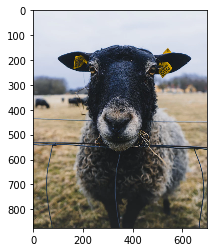

In [3]:
img_path = r'read_image/sheep.png'
img=mpimg.imread(img_path)
plt.imshow(img)

### Resizing image to fit the input size of VGG16 model.

In [4]:
img = image.load_img(img_path, target_size=(224, 224))

### Convert image to numpy array.

In [5]:
x = image.img_to_array(img)

### Reshaping the data into 'batch form' so that the model could accept it.

In [6]:
x = np.expand_dims(x, axis=0)

In [7]:
x.shape

(1, 224, 224, 3)

### Preprocessing

In [8]:
x = preprocess_input(x)

### Predictions

In [9]:
preds = model.predict(x)
predictions = pd.DataFrame(decode_predictions(preds, top=3)[0], columns=['column', 'categories', 'probability']).iloc[:, 1:]
print('Prediction:', predictions.loc[0, 'categories'])

Prediction: ram


Text(0.5, 1.0, 'Top 3 Predictions')

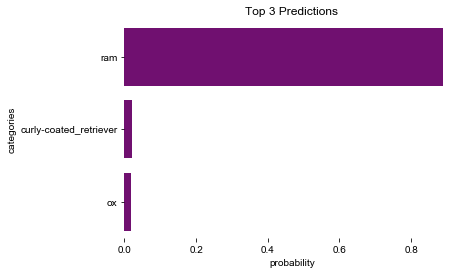

In [10]:
f = sns.barplot(x='probability', y='categories', data=predictions, color='purple')
sns.set_style(style='white')
f.grid(False)
f.spines['top'].set_visible(False)
f.spines['right'].set_visible(False)
f.spines['bottom'].set_visible(False)
f.spines['left'].set_visible(False)
f.set_title('Top 3 Predictions')

### Getting the index of the prediction.

In [11]:
argmax = np.argmax(preds[0])

In [12]:
output = model.output[:, argmax]

### Model Archtecture

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [14]:
last_conv_layer = model.get_layer('block5_conv3')

In [15]:
grads = K.gradients(output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])

In [16]:
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

### Plotting the Heatmap.

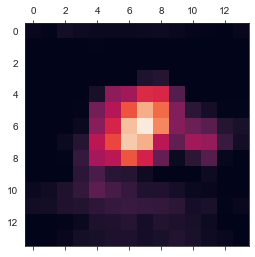

In [17]:
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

### Load image and resize the heatmap.

In [18]:
img = cv2.imread(img_path)

In [19]:
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

### Convert heatmap into 'RGB' and apply it to original Image.

In [20]:
heatmap = np.uint8(255 * heatmap)

In [21]:
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

### Apply heatmap intensity factor.

In [22]:
hif = .8

In [23]:
superimposed_img = heatmap * hif + img

### Save to disk and plot.

In [24]:
output = 'read_image/output_sheep.jpeg'
cv2.imwrite(output, superimposed_img)

img=mpimg.imread(output)

Text(0.5, 1.0, 'ram')

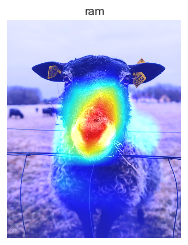

In [25]:
plt.imshow(img)
plt.axis('off')
plt.title(predictions.loc[0, 'categories'])